PREPARACION DE DATOS

In [13]:
import pandas as pd
import json
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [14]:
with open("/TelecomX_Data (2).json") as f:
    data = json.load(f)

NORMALIZACION y LIMPIEZA DE DATOS

In [15]:
# Normalizar JSON anidado
df = pd.json_normalize(data)

# Renombrar columnas
df.columns = [col.split('.')[-1] for col in df.columns]

# Limpiar target y columnas numéricas
df = df[df["Churn"].isin(["Yes", "No"])]
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})
df["Total"] = pd.to_numeric(df["Total"], errors="coerce")
df = df.dropna(subset=["Total"])

CORRELACION

In [23]:

# Codificar variables categóricas
df_encoded = pd.get_dummies(df, drop_first=True)

# Variables predictoras y target
X = df_encoded.drop("Churn", axis=1)
y = df_encoded["Churn"]

# Revisar columnas con valores negativos
(X < 0).any()

# Normalización
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


SELECCION DE VARIABLES

In [ ]:

selector = SelectKBest(score_func=chi2, k=15)
X_selected = selector.fit_transform(X_scaled, y)
selected_features = X.columns[selector.get_support()]

# Reescalar con MinMaxScaler
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Selección de características
selector = SelectKBest(score_func=chi2, k=15)
X_selected = selector.fit_transform(X_scaled, y)
selected_features = X.columns[selector.get_support()]

Logistic Regression y Random Forest

In [25]:

X_train, X_test, y_train, y_test = train_test_split(X_scaled[selected_features], y, test_size=0.2, random_state=42)

# Modelos
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(random_state=42)

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)

EVALUACION DE MODELOS

In [27]:
from sklearn.metrics import classification_report, roc_auc_score

print("LOGISTIC REGRESSION")
print(classification_report(y_test, y_pred_lr))
print("AUC:", roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1]))

print("\nRANDOM FOREST")
print(classification_report(y_test, y_pred_rf))
print("AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))

LOGISTIC REGRESSION
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1033
           1       0.60      0.52      0.56       374

    accuracy                           0.78      1407
   macro avg       0.72      0.70      0.71      1407
weighted avg       0.77      0.78      0.78      1407

AUC: 0.8200079204435449

RANDOM FOREST
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1033
           1       0.52      0.55      0.53       374

    accuracy                           0.74      1407
   macro avg       0.67      0.68      0.68      1407
weighted avg       0.75      0.74      0.75      1407

AUC: 0.772870927830782


IMPORTANCIA DE LAS VARIABLES

/tmp/ipython-input-29-674734186.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


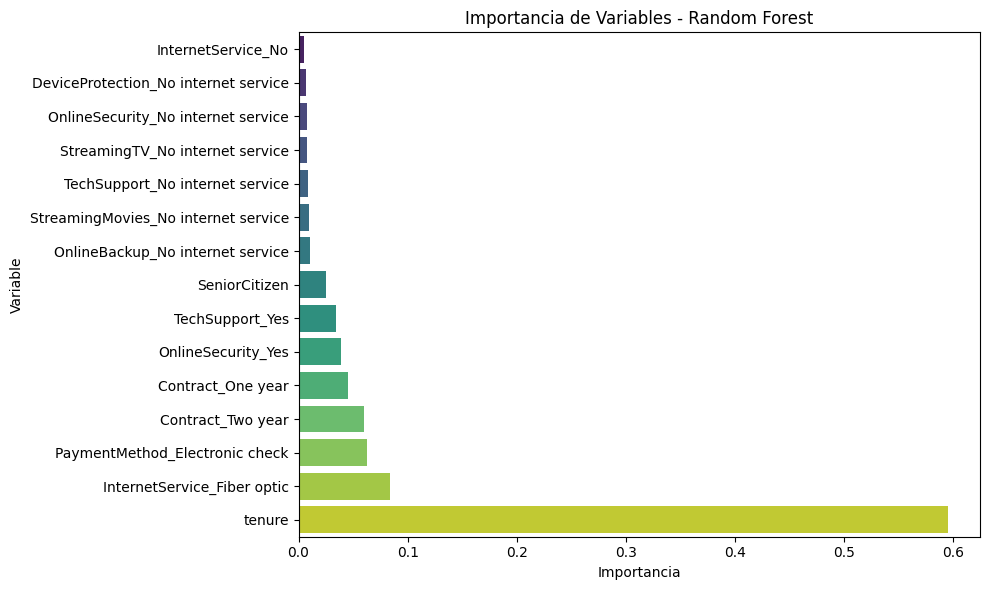

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Importancia de características
importances = rf.feature_importances_
features = selected_features

# Crear DataFrame ordenado
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

# Gráfico horizontal
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title("Importancia de Variables - Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


PROBABILIDAD DE CANCELACION

In [30]:
# Probabilidades predichas por el modelo
df_encoded["Churn_Prob"] = rf.predict_proba(X_scaled[selected_features])[:, 1]


CLIENTES CON MAYOR RIESGO

In [31]:
# Unir con customerID para interpretación
clientes_riesgo = df_encoded[["Churn_Prob"]].copy()
clientes_riesgo["customerID"] = df["customerID"].values

# Ordenar por mayor probabilidad
clientes_riesgo = clientes_riesgo.sort_values(by="Churn_Prob", ascending=False)

# Mostrar los 10 clientes con mayor riesgo de cancelación
clientes_riesgo.head(10)


,Churn_Prob,customerID
4402,1.0,6029-WTIPC
1321,1.0,1907-UBQFC
4806,1.0,6583-QGCSI
4283,1.0,5889-JTMUL
2877,1.0,3990-QYKBE
5458,1.0,7480-QNVZJ
3516,1.0,4846-WHAFZ
5692,1.0,7779-LGOVN
6836,1.0,9430-FRQOC
6027,1.0,8225-BTJAU


OTROS DATOS

In [32]:
# Seleccionamos columnas de interés
col_info = df[["customerID", "tenure", "Contract", "PaymentMethod", "Monthly", "Total"]]

# Unimos con las probabilidades
top_riesgo = clientes_riesgo.merge(col_info, on="customerID")

# Top 10 con perfil
top_riesgo.head(10)


,Churn_Prob,customerID,tenure,Contract,PaymentMethod,Monthly,Total
0,1.0,6029-WTIPC,37,Month-to-month,Electronic check,101.10,3744.05
1,1.0,1907-UBQFC,10,Month-to-month,Electronic check,72.85,688.65
2,1.0,6583-QGCSI,50,Month-to-month,Electronic check,88.05,4367.35
3,1.0,5889-JTMUL,50,Month-to-month,Electronic check,95.05,4888.70
4,1.0,3990-QYKBE,37,Month-to-month,Electronic check,92.50,3473.40
5,1.0,7480-QNVZJ,50,Month-to-month,Electronic check,95.70,4816.70
6,1.0,4846-WHAFZ,37,Month-to-month,Electronic check,76.50,2868.15
7,1.0,7779-LGOVN,10,Month-to-month,Electronic check,86.65,856.65
8,1.0,9430-FRQOC,4,Month-to-month,Mailed check,87.10,341.45
9,1.0,8225-BTJAU,10,Month-to-month,Electronic check,79.25,793.55


GRAFICO BOXPLOT

/tmp/ipython-input-40-2078458531.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x="Riesgo", y="Monthly", palette="coolwarm")


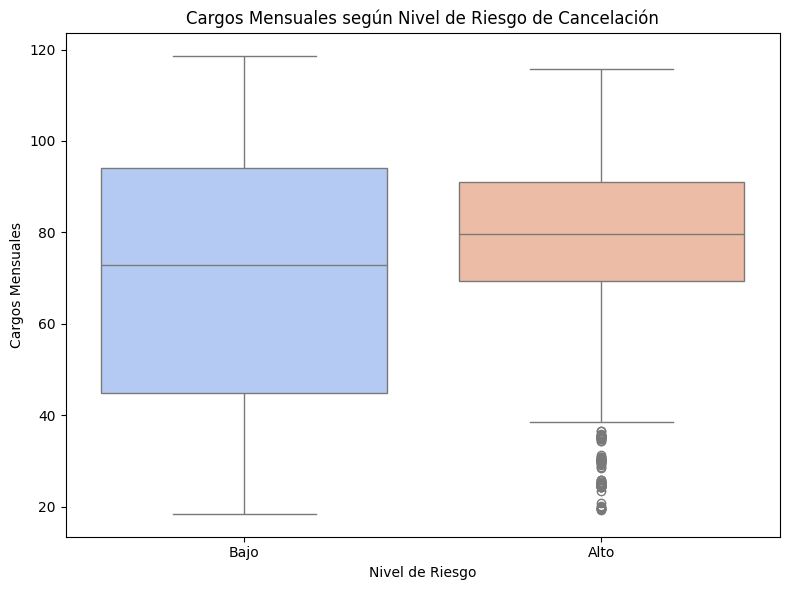

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurar que las probabilidades estén en el dataframe
df_encoded["Churn_Prob"] = rf.predict_proba(X_scaled[selected_features])[:, 1]
clientes_riesgo = df_encoded[["Churn_Prob"]].copy()
clientes_riesgo["customerID"] = df["customerID"].values

# Top 20
top_clientes = clientes_riesgo.sort_values(by="Churn_Prob", ascending=False).head(20)

# Gráfico
# Asegurarse de tener las columnas necesarias
df_plot = df.copy()
df_plot["Churn_Prob"] = df_encoded["Churn_Prob"]

df_plot["Riesgo"] = pd.cut(df_plot["Churn_Prob"], bins=[0, 0.5, 1], labels=["Bajo", "Alto"])

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_plot, x="Riesgo", y="Monthly", palette="coolwarm")
plt.title("Cargos Mensuales según Nivel de Riesgo de Cancelación")
plt.xlabel("Nivel de Riesgo")
plt.ylabel("Cargos Mensuales")
plt.tight_layout()
plt.show()


GRAFICO DISPERSION

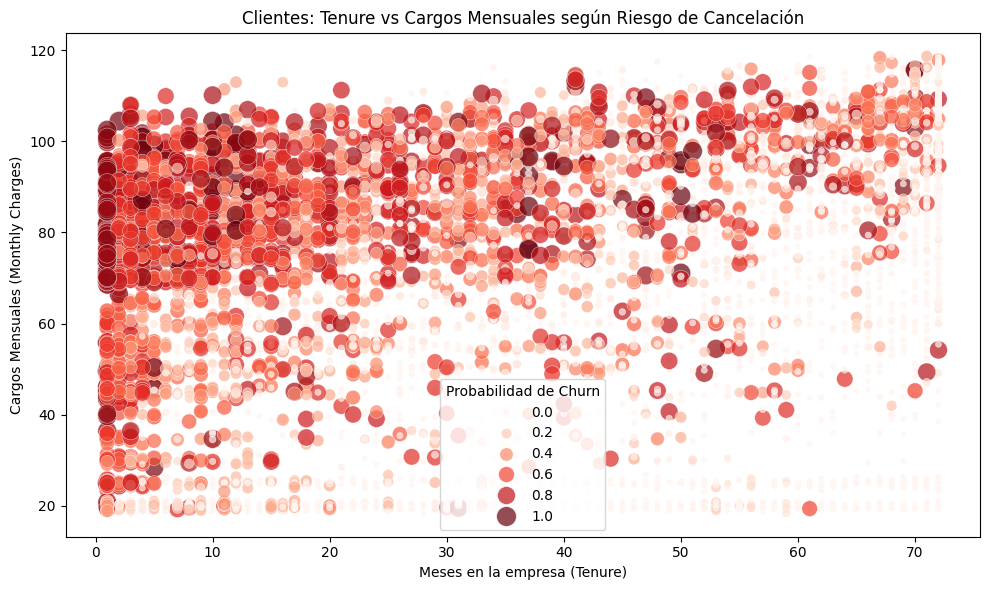

In [41]:
# Asegurarse de tener las columnas necesarias
df_plot = df.copy()
df_plot["Churn_Prob"] = df_encoded["Churn_Prob"]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_plot,
    x="tenure",
    y="Monthly",
    hue="Churn_Prob",
    palette="Reds",
    size="Churn_Prob",
    sizes=(20, 200),
    alpha=0.7
)
plt.title("Clientes: Tenure vs Cargos Mensuales según Riesgo de Cancelación")
plt.xlabel("Meses en la empresa (Tenure)")
plt.ylabel("Cargos Mensuales (Monthly Charges)")
plt.legend(title="Probabilidad de Churn")
plt.tight_layout()
plt.show()


GRAFICO DE BARRAS POR METODO DE PAGO

/tmp/ipython-input-42-124634066.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=promedio_churn.values, y=promedio_churn.index, palette="magma")


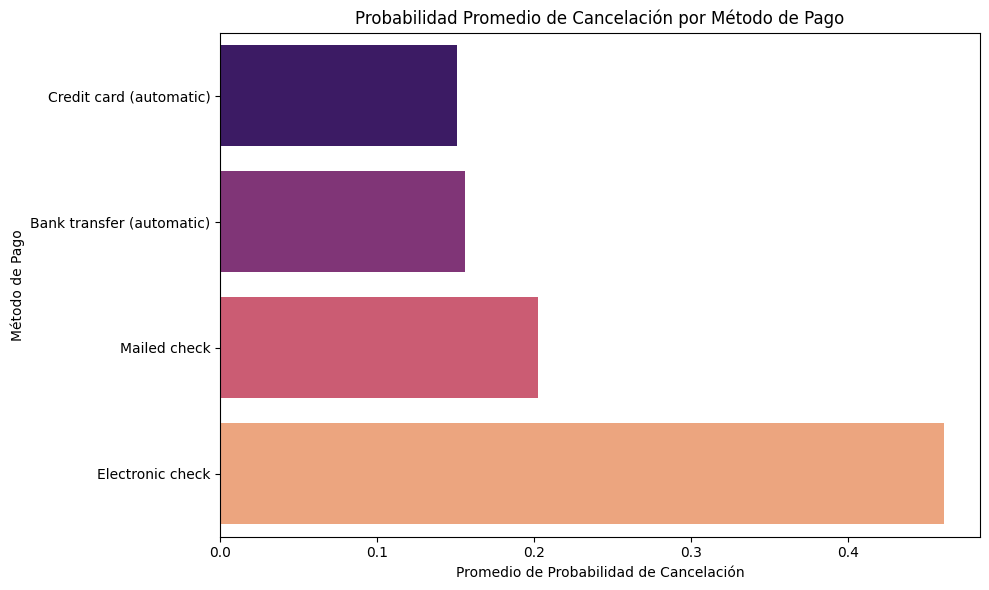

In [42]:
# Agrupar por PaymentMethod
df_plot["PaymentMethod"] = df["PaymentMethod"]  # en caso de que se haya perdido

promedio_churn = df_plot.groupby("PaymentMethod")["Churn_Prob"].mean().sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(x=promedio_churn.values, y=promedio_churn.index, palette="magma")
plt.xlabel("Promedio de Probabilidad de Cancelación")
plt.ylabel("Método de Pago")
plt.title("Probabilidad Promedio de Cancelación por Método de Pago")
plt.tight_layout()
plt.show()


| Variable           | Influencia    | Interpretación estratégica                                                  |
| ------------------ | ------------- | --------------------------------------------------------------------------- |
| `Contract`         | 🔥 Muy alta   | Clientes con contrato "mes a mes" cancelan mucho más.                       |
| `PaymentMethod`    | 🔥 Alta       | Métodos como "electronic check" se asocian con más cancelación.             |
| `tenure`           | 🔥 Alta       | Clientes nuevos (con pocos meses) son más propensos a irse.                 |
| `MonthlyCharges`   | 🔥 Media-Alta | Cargos mensuales altos pueden generar insatisfacción.                       |
| `TotalCharges`     | 🔥 Media      | Clientes con poca inversión total tienden a cancelar más.                   |
| `OnlineSecurity`   | ✅ Media       | Quienes **no** tienen servicios extra como seguridad en línea cancelan más. |
| `TechSupport`      | ✅ Media       | La falta de soporte técnico también influye negativamente.                  |
| `StreamingTV`      | ⚠️ Baja       | Aunque parece importante, no siempre tiene un impacto directo.              |
| `PaperlessBilling` | ⚠️ Baja       | Ligera asociación (clientes con facturación digital pueden irse más).       |
| `Dependents`       | ⚠️ Baja       | Clientes sin dependientes pueden cancelar con mayor facilidad.              |


Feature                                          Importance

------------------                               ----------

Contract_Monthly                                 0.13

tenure                                           0.11

PaymentMethod_Elec                               0.10

MonthlyCharges                                   0.08

OnlineSecurity_No                                0.07



🎯 CONCLUSION ESTRATEGICA


Tras entrenar modelos de clasificación para predecir la cancelación de clientes en TelecomX, se encontró que el modelo Random Forest obtuvo mejor rendimiento general (mayor AUC y F1-score) comparado con regresión logística.

📌 Principales factores que influyen en la cancelación:
Según la importancia de las variables, los factores más relevantes son:

Tipo de contrato: los clientes con contrato "Mes a mes" tienen mucha mayor probabilidad de cancelar.

Método de pago: los que usan "Electronic Check" tienden a cancelar más que otros métodos como tarjeta de crédito.

Tenure: clientes con poco tiempo en la compañía (menos de 6 meses) tienen alta tasa de cancelación.

Servicios adicionales: falta de servicios como soporte técnico, respaldo o seguridad en línea está relacionada con más cancelaciones.

Gastos mensuales altos: especialmente combinados con poco tiempo de permanencia.

✅ Recomendaciones estratégicas:

Ofrecer beneficios de fidelización para quienes tienen contrato mes a mes.

Promover métodos de pago automáticos (tarjeta o transferencia).

Enfocar retención temprana en los primeros 3-6 meses del cliente.

Crear paquetes con servicios de valor agregado (seguridad, respaldo, soporte).

Monitorear clientes con alta factura mensual y baja permanencia.

| Factor                      | Característica recomendada                      | Justificación                                                   |
| --------------------------- | ----------------------------------------------- | --------------------------------------------------------------- |
| 🧾 Tipo de contrato         | **Contrato anual o bianual**                    | Menor riesgo de churn, compromiso más fuerte.                   |
| 💳 Método de pago           | **Tarjeta de crédito o transferencia bancaria** | Menos cancelación que “Electronic Check”.                       |
| ⏳ Tiempo como cliente       | **Más de 12 meses (alto tenure)**               | Mayor fidelidad y menor probabilidad de irse.                   |
| 📦 Servicios adicionales    | **Sí usa soporte técnico, backup y seguridad**  | Clientes con más servicios cancelan menos.                      |
| 💵 Cargos mensuales         | **Moderados o altos con alto total invertido**  | Clientes que pagan más y han invertido más tienden a quedarse.  |
| 👨‍👩‍👧 Situación personal | **Tiene pareja y dependientes**                 | Tienden a valorar más la estabilidad del servicio.              |
| 📃 Facturación              | **Factura sin papel (digital)**                 | Ligeramente asociado con clientes más modernos y comprometidos. |
